In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors

In [2]:
savename='XTime_Tshadow'

In [3]:
# Global path = "/global/scratch/users/adac/Slope_Flow/SlopeFlow/WRFV3/LES3/"
# Template file = "wrfout_d01_2014-03-21_12:00:00"

path = "../WRFV3/LES3_sunset"
file= "wrfout_d01_2014-03-21_17:30:00"

L1 = 3e3
L2 = 1e3

slope1 = 3*np.pi/180.
slope2 = 5*np.pi/180.

ds = xr.open_dataset(path+'/'+file)#+'.nc')
ds

<xarray.Dataset>
Dimensions:                (Time: 61, south_north: 149, west_east: 399,
                            bottom_top: 68, bottom_top_stag: 69,
                            soil_layers_stag: 4, west_east_stag: 400,
                            south_north_stag: 150)
Coordinates:
    XLAT                   (Time, south_north, west_east) float32 ...
    XLONG                  (Time, south_north, west_east) float32 ...
    XTIME                  (Time) datetime64[ns] ...
    XLAT_U                 (Time, south_north, west_east_stag) float32 ...
    XLONG_U                (Time, south_north, west_east_stag) float32 ...
    XLAT_V                 (Time, south_north_stag, west_east) float32 ...
    XLONG_V                (Time, south_north_stag, west_east) float32 ...
Dimensions without coordinates: Time, south_north, west_east, bottom_top,
                                bottom_top_stag, soil_layers_stag,
                                west_east_stag, south_north_stag
Data variables: (12/153)
    Times                  (Time) |S19 ...
    LU_INDEX               (Time, south_north, west_east) float32 ...
    ZNU                    (Time, bottom_top) float32 ...
    ZNW                    (Time, bottom_top_stag) float32 ...
    ZS                     (Time, soil_layers_stag) float32 ...
    DZS                    (Time, soil_layers_stag) float32 ...
    ...                     ...
    PCB                    (Time, south_north, west_east) float32 ...
    PC                     (Time, south_north, west_east) float32 ...
    LANDMASK               (Time, south_north, west_east) float32 ...
    LAKEMASK               (Time, south_north, west_east) float32 ...
    SST                    (Time, south_north, west_east) float32 ...
    SST_INPUT              (Time, south_north, west_east) float32 ...
Attributes: (12/119)
    TITLE:                            OUTPUT FROM WRF V3.9.1.1 MODEL
    START_DATE:                      2014-03-21_17:30:00
    SIMULATION_START_DATE:           2014-03-21_12:00:00
    WEST-EAST_GRID_DIMENSION:        400
    SOUTH-NORTH_GRID_DIMENSION:      150
    BOTTOM-TOP_GRID_DIMENSION:       69
    ...                              ...
    ISLAKE:                          0
    ISICE:                           0
    ISURBAN:                         0
    ISOILWATER:                      0
    HYBRID_OPT:                      -1
    ETAC:                            0.0

In [4]:
times = ds['Times']
nt = len(times)
dt = 0.5/60 # 30 s/60(s/min)/60(min/hr) = dt [hrs] 
tv = np.arange(0,nt*dt,dt).T + 17.5 # starts 17:30

In [5]:
#nz = ds.dims["bottom_top"]
#ny = ds.dims["south_north"]
nx = ds.dims["west_east"]
ixstart = nx//2 + 1 #+ 1 to start on slope not peak
dx = ds.attrs['DX']
ixend = nx//2+int( (1+3)*1e3/dx ) + 1 #(L2 = 1km + L1 = 3)dx
xmid = nx/2*dx
xmid

9975.0

In [6]:
xv = np.arange(dx/2,nx*dx,dx) - xmid
x = np.tile(xv, (nt,1))
x.shape

(61, 399)

In [7]:
t = np.tile(tv, (nx,1)).T
t.shape

(61, 399)

In [8]:
sw = ds['SWNORM'].mean(dim=["south_north"])
sw

<xarray.DataArray 'SWNORM' (Time: 61, west_east: 399)>
array([[102.72149  , 102.72151  , 102.72162  , ..., 102.721565 ,
        102.72153  , 102.72147  ],
       [100.617165 , 100.617256 , 100.617355 , ..., 100.61718  ,
        100.61714  , 100.61712  ],
       [ 98.51877  ,  98.51892  ,  98.51901  , ...,  98.51872  ,
         98.51874  ,  98.51872  ],
       ...,
       [  4.0108566,   4.0108585,   4.0108566, ...,   4.010842 ,
          4.0108423,   4.010847 ],
       [  3.280539 ,   3.2805378,   3.2805376, ...,   3.2805257,
          3.2805283,   3.2805302],
       [  2.6220224,   2.6220217,   2.6220205, ...,   2.6220105,
          2.6220133,   2.6220148]], dtype=float32)
Coordinates:
    XTIME    (Time) datetime64[ns] ...
Dimensions without coordinates: Time, west_east

In [9]:
t_shadow = np.empty( nx )
iL2end = nx//2+int( L2/dx )

t_shadow[ixstart:iL2end] = 18 - 12/np.pi*slope2
t_shadow[iL2end:ixend] = 18 - 12/np.pi*np.arctan( np.tan(slope1) + L2 / xv[iL2end:ixend] * (np.tan(slope2) - np.tan(slope1)) )

In [10]:
refine = 5
uppers = range(0,45+1,refine)
lowers = range(0,45+1,refine)

tau = np.full( ( len(uppers), len(lowers) ), np.nan) 

for upper in uppers:
    # print('upper is '+str(upper))
    for lower in range(upper,-1,-1):
        # print(lower)
        s1 = lower*np.pi/180.
        s2 = upper*np.pi/180.

        tau[ lower//refine, upper//refine ] = 12/np.pi*( np.arctan( np.tan(s2) ) - np.arctan( np.tan(s1) + (np.tan(s2) - np.tan(s1))/4.0 ) )   

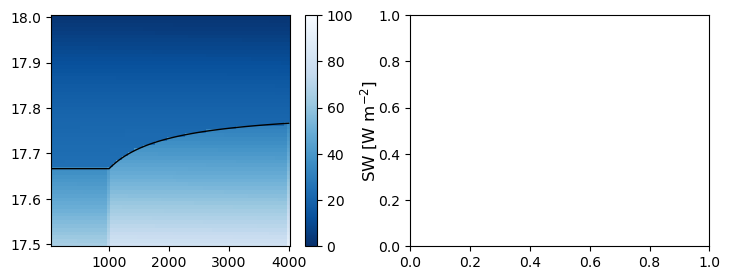

In [11]:
try:
    del(fig, axs)
    print("deleted old figure")
    fig, axs = plt.subplots( 1, 2, figsize=(8, 3) , cpnstrained_layout = True)
except:
    fig, axs = plt.subplots( 1, 2, figsize=(8.5, 3) )
    
cbarLabels = [r'SW [W m$^{-2}$]']
vmin = 0
vmax = 100

cf2 = axs[0].pcolor( x[:,ixstart:ixend], t[:,ixstart:ixend],sw[:,ixstart:ixend].values, cmap="Blues_r", vmin=vmin, vmax=vmax)
# vmin, vmax = cf.get_clim()

cb = plt.colorbar(
    cf2,
    ax=axs[0],
    norm=matplotlib.colors.Normalize(vmin=vmin, vmax=vmax),
    cmap="Blues_r")
cb.set_label(cbarLabels[0],fontsize=12)

shd = axs[0].plot(xv[ixstart:ixend], t_shadow[ixstart:ixend], 'k', linewidth=1)

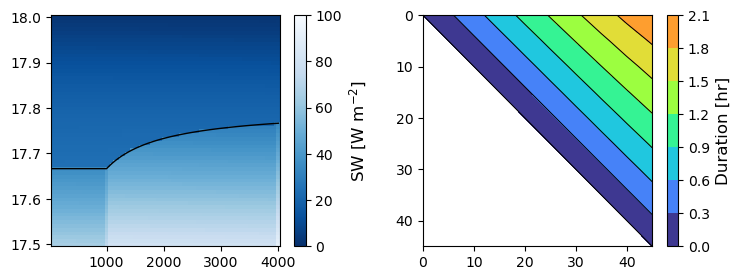

<Figure size 640x480 with 0 Axes>

In [12]:
#fig, axs = plt.subplots( 1, 2, figsize=(12, 4) )
cbarLabels = [r'Duration [hr]']
vmin = 0
vmax = 2.75

cf1 = axs[1].contourf( uppers, lowers, tau, cmap='turbo', vmin = vmin, vmax = vmax)
levels = cf1.levels
axs[1].contour( uppers, lowers, tau, colors = 'black', linewidths=0.75, levels = levels)
# vmin, vmax = cf.get_clim()
axs[1].invert_yaxis()

cb = plt.colorbar(
    cf1,
    ax=axs[1],
    norm=matplotlib.colors.Normalize(vmin=vmin, vmax=vmax),
    cmap="turbo",label=cbarLabels[0]
)
cb.set_label(cbarLabels[0],fontsize=12)
fig.subplots_adjust(wspace=0.3)
fig

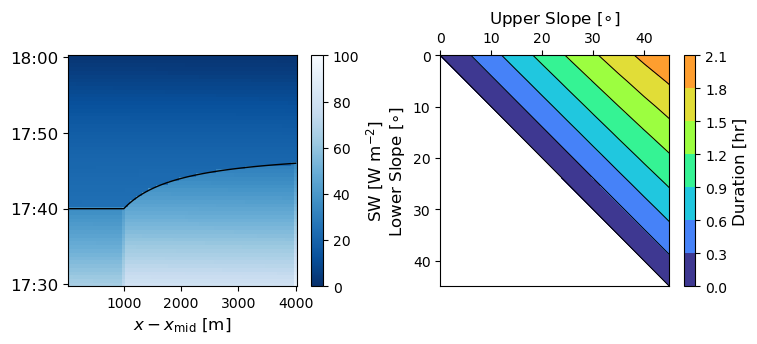

In [13]:
axs[1].set_ylabel(r'Lower Slope [$\circ$]', size=12)
axs[1].xaxis.set_label_position('top')  # Move label to top
axs[1].xaxis.tick_top() 
axs[1].set_title(r'Upper Slope [$\circ$]', size=12)
axs[0].set_xlabel(r'$x-x_{\text{mid}}$ [m]', size=12)
axs[0].set_yticks([17.5, 17.+40./60. , 17.+50./60. , 18])
axs[0].set_yticklabels(['17:30', '17:40', '17:50', '18:00'], size=12)
fig

In [14]:
save=True
if save:
    plt.figure(fig)
    fmts=["png","eps"]
    for fmt in fmts:
        plt.savefig("plots/"+savename+"."+fmt, format=fmt)